In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

# Getting quotes related to climate change

In [2]:
reg_query = "|".join(["climate", "global warming", "greenhouse gas", "gas emissions", "greenhouse effect", "pesticide", "pollution", "carbon emissions"])

In [4]:
reg_query

'climate|global warming|greenhouse gas|gas emissions|greenhouse effect|pesticide|pollution|carbon emissions'

In [7]:
df_reader = pd.read_json('data/quotebank/quotes-2020.json.bz2', lines=True, compression='bz2', chunksize =100000)

In [6]:
%%time
climate_like_quotes = []
for chunk in df_reader:
    df = chunk[chunk.quotation.str.contains(reg_query, case=False, na=False)]
    climate_like_quotes.append(df)

CPU times: user 5min 22s, sys: 6.49 s, total: 5min 28s
Wall time: 5min 28s


In [8]:
climate_like_df = pd.concat(climate_like_quotes)

In [9]:
climate_like_df.shape

(22690, 9)

In [100]:
climate_like_df.quotation.iloc[1401]

"We have international students who are worried about what's going on in Australia... I think some of the worry is the air pollution. People have seen the pictures of the red sky."

In [11]:
climate_like_df.to_pickle('data/climate_like_2020.pkl')

In [4]:
climate_df = pd.read_pickle("data/climate_df_2020.pkl")

# Basic analysis

In [3]:
climate_dfs = {}
for y in range(2015, 2021):
    climate_dfs[y] = pd.read_pickle('data/climate_df_{}.pkl'.format(y))

In [4]:
full_climate_df = pd.DataFrame(columns = climate_dfs[2015].columns)
for y in range(2018, 2020):
    full_climate_df = full_climate_df.append(climate_dfs[y])

## Cleaning dataset

In [3]:
%%time
# load wiki data
wiki_data = pd.read_parquet('parquet-data/speaker_attributes.parquet')

CPU times: user 12.2 s, sys: 2.79 s, total: 15 s
Wall time: 11.9 s


In [155]:
full_climate_df.loc[1266]

quoteID                                           2015-09-09-008765
quotation         As siltation is a natural process in the Meghn...
speaker                                         Anisul Islam Mahmud
qids                                                    [Q23762578]
date                                            2015-09-09 07:40:37
numOccurrences                                                   11
probas                [[Anisul Islam Mahmud, 0.942], [None, 0.058]]
urls              [http://trust.org/item/20150909073825-39czr, h...
phase                                                             E
Name: 1266, dtype: object

In [66]:
def replace_name(q, qids_to_name={}):
    if 0 < len(q.qids):
        if q.qids[0] not in qids_to_name:
            qids_to_name[q.qids[0]] = q.speaker
        else:
            q.speaker = qids_to_name[q.qids[0]]
    return q
    

In [67]:
%%time
full_climate_df = full_climate_df.apply(replace_name, axis=1)

CPU times: user 9.06 s, sys: 138 ms, total: 9.2 s
Wall time: 9.2 s


## Getting top speakers

In [68]:
def get_top_speakers(df):
    """function to extract the top 10 speakers"""
    
    top_speakers = df[df.speaker != "None"].groupby('speaker')['speaker'].count().sort_values(ascending=False).to_frame().add_suffix('_count')
    top_speakers.reset_index(drop=False, inplace=True)
    
    return top_speakers

In [104]:
def get_top_speakers_by_year(df):
    top_speakers = pd.DataFrame()
    for y in range(2015, 2021):
        count = df[df.date.dt.year == y].query('speaker != "None"').groupby('speaker')['quoteID'].count().sort_values(ascending=False).to_frame()
        count = count.rename(columns={"quoteID": "count"})
        count.reset_index(inplace=True)
        count.insert(0, 'year', y)
        count.insert(3, 'rank_in_year', count.index + 1)
        top_speakers = top_speakers.append(count)
    return top_speakers.reset_index(drop=True)
        

In [105]:
get_top_speakers_by_year(full_climate_df)

,year,speaker,count,rank_in_year
0,2018,President Trump,328,1
1,2018,Antonio Guterres,289,2
2,2018,Catherine McKenna,273,3
3,2018,Jerry Brown,228,4
4,2018,Michael Mann,193,5
...,...,...,...,...
31829,2019,Jedediah Purdy,1,17321
31830,2019,Jeff Adams,1,17322
31831,2019,Jeff Allen,1,17323
31832,2019,Jeff Atkins,1,17324


In [112]:
%%time
top_speakers.apply(lambda x: full_climate_df[full_climate_df.speaker == x.speaker].qids, axis=1)

KeyboardInterrupt: 

In [70]:
top_speakers = get_top_speakers(full_climate_df)

In [71]:
top_speakers[:10]

,speaker,speaker_count
0,Antonio Guterres,895
1,Jay Inslee,723
2,Greta Thunberg,713
3,President Trump,663
4,Bernie Sanders,547
5,Catherine McKenna,542
6,Alexandria Ocasio-Cortez,476
7,Justin Trudeau,413
8,Michael Mann,345
9,Narendra Modi,335


In [74]:
top_speakers[top_speakers.speaker.str.contains("Obama")]

,speaker,speaker_count
22,Barack Obama,215
1025,Michelle Obama,12


In [75]:
top_speakers_by_year = get_top_speakers_by_year(full_climate_df)

In [76]:
top_speakers_by_year.head()

,year,speaker,count,rank_in_year
0,2018,President Trump,328,1
1,2018,Antonio Guterres,289,2
2,2018,Catherine McKenna,273,3
3,2018,Jerry Brown,228,4
4,2018,Michael Mann,193,5


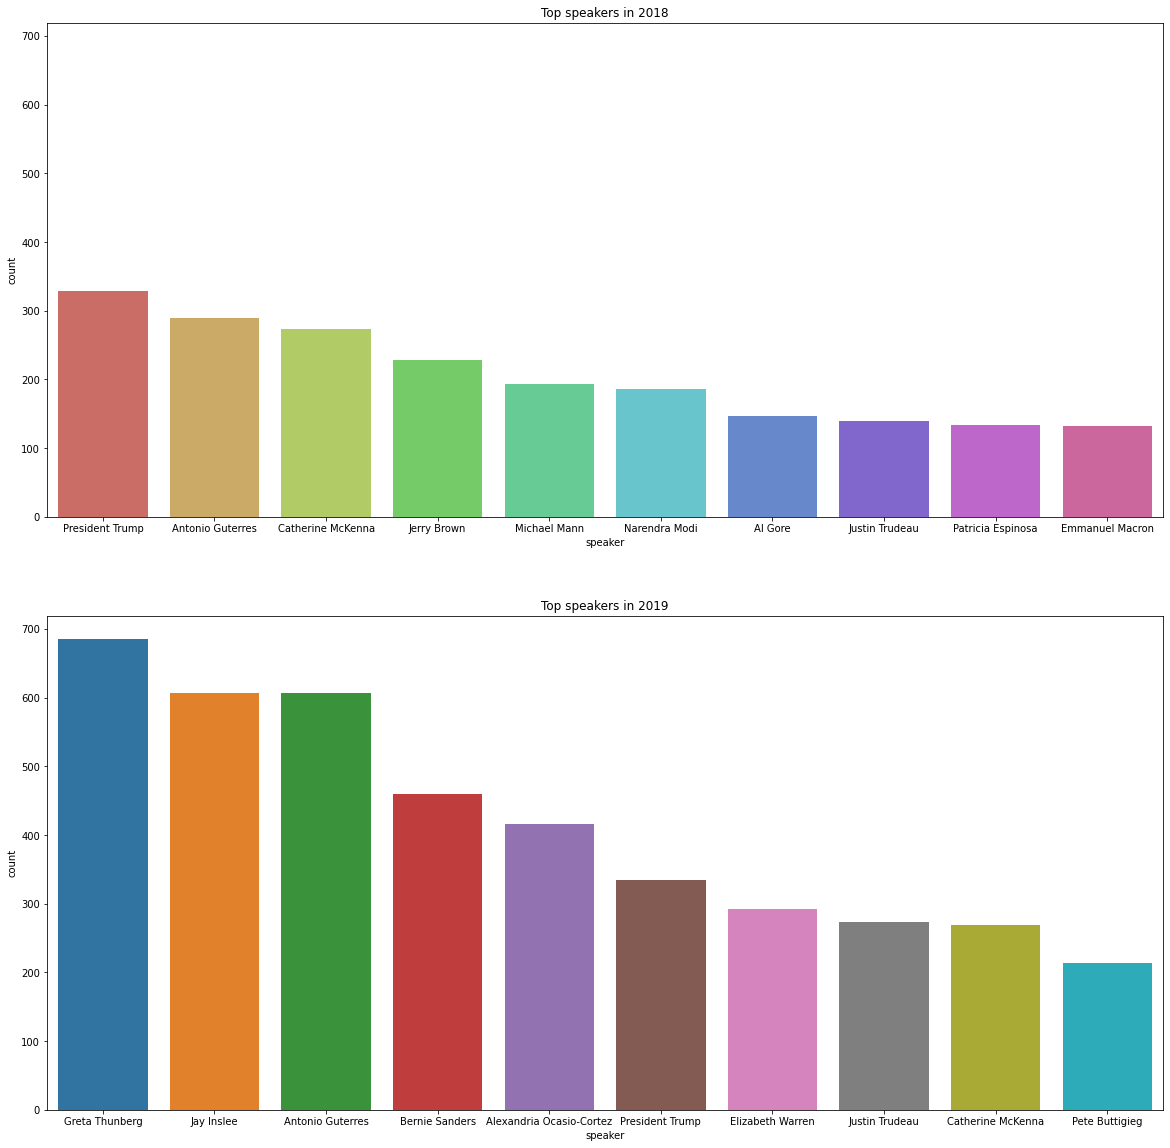

In [77]:
def plot_top_speakers_by_year(df):
    fig, ax = plt.subplots(2, figsize=(20,20), sharey=True)
    for i, y in enumerate(range(2018, 2020)):
        ax[i].set_title('Top speakers in {}'.format(y))
        curr_df = df[df.year == y][:10]
        sns.barplot(ax = ax[i], x=curr_df['speaker'], y=curr_df['count'], palette="tab10" if i > 0 else "hls")
    plt.show()

plot_top_speakers_by_year(top_speakers_by_year)

## Getting top quotes

In [88]:
def get_top_quotations(df):
    """function to extract the top 10 msot repeated quotations"""
    
    top_quotations = df[df.speaker != 'None'].sort_values('numOccurrences', ascending=False)[['speaker', 'quotation', 'numOccurrences', 'qids' ,'date']]
    # remove quotations of unidentified speakers
    top_quotations.insert(0, column='year', value=top_quotations.date.dt.year)
    top_quotations = top_quotations.loc[:, top_quotations.columns != 'date']
    top_quotations.reset_index(drop=True, inplace=True)
    
    return top_quotations

In [89]:
top_quotations = get_top_quotations(full_climate_df)

In [91]:
top_quotations.head()

,year,speaker,quotation,numOccurrences,qids
0,2018,Valeri Liukin,"the present climate causes me, and more import...",578,[Q558567]
1,2019,Gavin Newsom,You don't believe in climate change. You are e...,474,[Q461391]
2,2019,President Trump,"You're bang out of order, you're wrong... you ...",463,"[Q22686, Q27947481]"
3,2018,Greta Thunberg,School strike for the Climate.,425,[Q56434717]
4,2019,Nancy Pelosi,We must ensure a climate of integrity and dign...,407,[Q170581]


## Gender analysis

In [46]:
wiki_speakers = pd.read_pickle('data/wiki_speakers.pkl')

In [41]:
wiki_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
Q23762578,None,[+1947-12-20T00:00:00Z],"[Q902, Q843]",[Q6581097],1319692653,None,None,[Q82955],[Q1361491],None,Q23762578,Anisul Islam Mahmud,None,item,[Q432]
Q18199405,None,[+1963-08-13T00:00:00Z],[Q34],[Q6581097],1280534852,None,None,[Q1281618],None,None,Q18199405,Anders Jansson,None,item,None
Q5415483,None,[+1981-11-01T00:00:00Z],[Q30],[Q6581097],1378227353,None,None,"[Q19204627, Q15295720]",None,None,Q5415483,Evan Mathis,None,item,None
Q4911497,"[Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...",[+1961-05-08T00:00:00Z],[Q30],[Q6581097],1393528151,None,None,"[Q82955, Q40348]",[Q29552],None,Q4911497,Bill de Blasio,None,item,None
Q3061333,[Evan Lee Scribner],[+1985-07-19T00:00:00Z],[Q30],[Q6581097],1377322587,None,None,[Q10871364],None,None,Q3061333,Evan Scribner,None,item,None


In [21]:
wiki_labels = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [39]:
wiki_speakers.iloc[3]

aliases               [Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...
date_of_birth                                   [+1961-05-08T00:00:00Z]
nationality                                                       [Q30]
gender                                                             male
lastrevid                                                    1393528151
ethnic_group                                                       None
US_congress_bio_ID                                                 None
occupation                                             [Q82955, Q40348]
party                                                          [Q29552]
academic_degree                                                    None
id                                                             Q4911497
label                                                    Bill de Blasio
candidacy                                                          None
type                                                            

In [47]:
# get the gender of the speaker
def get_gender(speaker, genders = {}):
    if speaker.gender is not None:
        gender_id = speaker.gender[0]
        if gender_id in genders:
            speaker.gender = genders[gender_id]
        else:
            gender = wiki_labels.loc[gender_id]['Label']
            speaker.gender = gender
            genders[gender_id] = gender
    
    return speaker

In [48]:
wiki_speakers.apply(get_gender, axis=1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
Q23762578,None,[+1947-12-20T00:00:00Z],"[Q902, Q843]",male,1319692653,None,None,[Q82955],[Q1361491],None,Q23762578,Anisul Islam Mahmud,None,item,[Q432]
Q18199405,None,[+1963-08-13T00:00:00Z],[Q34],male,1280534852,None,None,[Q1281618],None,None,Q18199405,Anders Jansson,None,item,None
Q5415483,None,[+1981-11-01T00:00:00Z],[Q30],male,1378227353,None,None,"[Q19204627, Q15295720]",None,None,Q5415483,Evan Mathis,None,item,None
Q4911497,"[Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...",[+1961-05-08T00:00:00Z],[Q30],male,1393528151,None,None,"[Q82955, Q40348]",[Q29552],None,Q4911497,Bill de Blasio,None,item,None
Q3061333,[Evan Lee Scribner],[+1985-07-19T00:00:00Z],[Q30],male,1377322587,None,None,[Q10871364],None,None,Q3061333,Evan Scribner,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q19271892,None,[+1959-00-00T00:00:00Z],[Q145],male,1392939803,None,None,[Q43845],None,None,Q19271892,Chris Banks,None,item,None
Q15815037,None,[+1964-09-08T00:00:00Z],"[Q225, Q36704]",female,1375826663,None,None,[Q1476215],None,None,Q15815037,Dunja Mijatović,None,item,None
Q43911177,None,None,None,male,985959416,None,None,[Q5131856],None,None,Q43911177,James Meldrum,None,item,None
Q5087105,None,[+1954-11-22T00:00:00Z],[Q30],male,1315183141,None,None,"[Q43845, Q3282637]",None,None,Q5087105,Chase Carey,None,item,None


In [55]:
# get the age of the speaker
def get_age(speaker):
    if speaker.date_of_birth is not None:
        birth_date = speaker.date_of_birth[0]
        birth_year = birth_date[1:5]
        speaker.date_of_birth = int(datetime.now().strftime('%Y')) - int(birth_year)
        
    return speaker

In [56]:
wiki_speakers.apply(get_age, axis=1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
Q23762578,None,74.0,"[Q902, Q843]",male,1319692653,None,None,[Q82955],[Q1361491],None,Q23762578,Anisul Islam Mahmud,None,item,[Q432]
Q18199405,None,58.0,[Q34],male,1280534852,None,None,[Q1281618],None,None,Q18199405,Anders Jansson,None,item,None
Q5415483,None,40.0,[Q30],male,1378227353,None,None,"[Q19204627, Q15295720]",None,None,Q5415483,Evan Mathis,None,item,None
Q4911497,"[Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...",60.0,[Q30],male,1393528151,None,None,"[Q82955, Q40348]",[Q29552],None,Q4911497,Bill de Blasio,None,item,None
Q3061333,[Evan Lee Scribner],36.0,[Q30],male,1377322587,None,None,[Q10871364],None,None,Q3061333,Evan Scribner,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q19271892,None,62.0,[Q145],male,1392939803,None,None,[Q43845],None,None,Q19271892,Chris Banks,None,item,None
Q15815037,None,57.0,"[Q225, Q36704]",female,1375826663,None,None,[Q1476215],None,None,Q15815037,Dunja Mijatović,None,item,None
Q43911177,None,NaN,None,male,985959416,None,None,[Q5131856],None,None,Q43911177,James Meldrum,None,item,None
Q5087105,None,67.0,[Q30],male,1315183141,None,None,"[Q43845, Q3282637]",None,None,Q5087105,Chase Carey,None,item,None


In [62]:
wiki_speakers = wiki_speakers.rename(columns={"date_of_birth": "age"})

In [63]:
wiki_speakers

,aliases,age,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
Q23762578,None,74,"[Q902, Q843]",male,1319692653,None,None,[Q82955],[Q1361491],None,Q23762578,Anisul Islam Mahmud,None,item,[Q432]
Q18199405,None,58,[Q34],male,1280534852,None,None,[Q1281618],None,None,Q18199405,Anders Jansson,None,item,None
Q5415483,None,40,[Q30],male,1378227353,None,None,"[Q19204627, Q15295720]",None,None,Q5415483,Evan Mathis,None,item,None
Q4911497,"[Warren Wilhelm, Jr., Bill deBlasio, Warren Wi...",60,[Q30],male,1393528151,None,None,"[Q82955, Q40348]",[Q29552],None,Q4911497,Bill de Blasio,None,item,None
Q3061333,[Evan Lee Scribner],36,[Q30],male,1377322587,None,None,[Q10871364],None,None,Q3061333,Evan Scribner,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q19271892,None,62,[Q145],male,1392939803,None,None,[Q43845],None,None,Q19271892,Chris Banks,None,item,None
Q15815037,None,57,"[Q225, Q36704]",female,1375826663,None,None,[Q1476215],None,None,Q15815037,Dunja Mijatović,None,item,None
Q43911177,None,None,None,male,985959416,None,None,[Q5131856],None,None,Q43911177,James Meldrum,None,item,None
Q5087105,None,67,[Q30],male,1315183141,None,None,"[Q43845, Q3282637]",None,None,Q5087105,Chase Carey,None,item,None


In [84]:
top_speakers_by_year

,year,speaker,count,rank_in_year
0,2018,President Trump,328,1
1,2018,Antonio Guterres,289,2
2,2018,Catherine McKenna,273,3
3,2018,Jerry Brown,228,4
4,2018,Michael Mann,193,5
...,...,...,...,...
31829,2019,Jedediah Purdy,1,17321
31830,2019,Jeff Adams,1,17322
31831,2019,Jeff Allen,1,17323
31832,2019,Jeff Atkins,1,17324


In [ ]:
# add gender and age to top speakers by year
top_speakers_by_year['gender'] = top_speakers_by_year.apply(lambda row: )

AttributeError: 'DataFrame' object has no attribute 'gender'

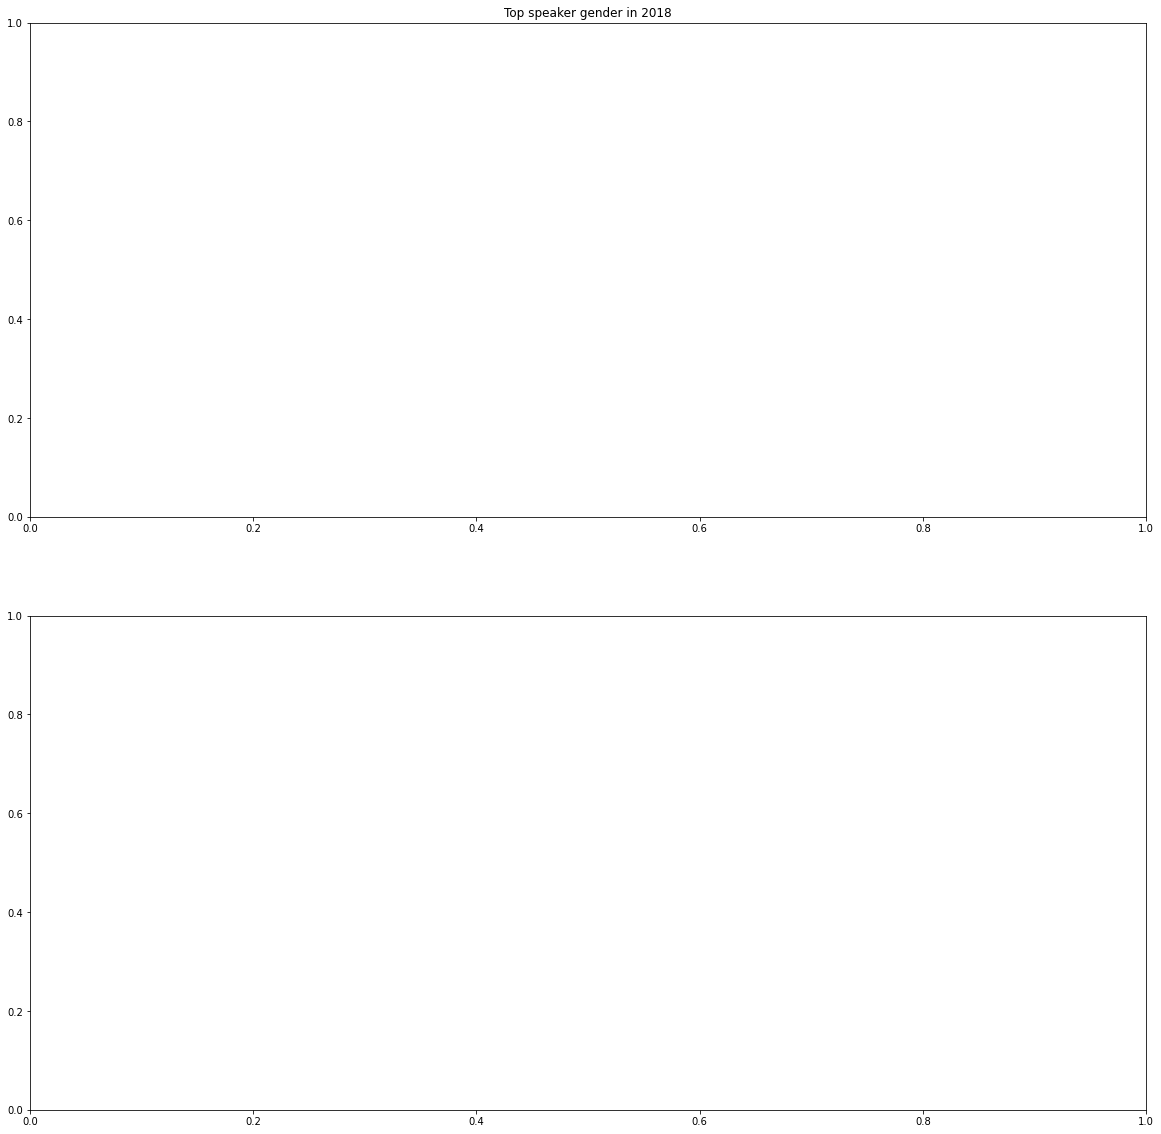

In [86]:
def plot_top_speakers_gender(df):
    fig, ax = plt.subplots(2, figsize=(20,20), sharey=True)
    for i, y in enumerate(range(2018, 2020)):
        ax[i].set_title('Top speaker gender in {}'.format(y))
        curr_df = df[df.year == y][:100]
        ax[i].pie([curr_df[curr_df.gender == 'men'].count, curr_df[curr_df.gender == 'women'].count], labels=['men', 'women'], autopct='%1.0f%%' )
#        ax1.pie([nb_men_2018, nb_women_2018], labels=['men', 'women'], autopct='%1.0f%%')
    plt.show()

plot_top_speakers_gender(top_speakers_by_year)